<a href="https://colab.research.google.com/github/snilsn/lanczos/blob/main/lanczos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating eigenvalue spectrum of the hessian for larger neural networks



In [ ]:
import tensorflow as tf
import numpy as np
from scipy.linalg import eigh_tridiagonal
from scipy.stats import gaussian_kde as kde
import matplotlib.pyplot as plt
import time 
from numba import njit

tf.random.set_seed(1234)
np.random.seed(1234)

## naive hessian extraction

The functions in the following block can be used to extract the full hessian matrix and eigenvalue spectrum of a tensorflow model. For models with a large number of parameters this takes a long time.

In [ ]:
@njit
def eigenvals(A):
    """
    input:    symmetric matrix
    output:   eigenvalues of the matrix as array

    accelerated with the @njit decorateur of the numba compiler, first call takes additional compilation time

    """
    return np.linalg.eigvalsh(A)

def get_parameter_number(model):

    """
    input:    tensorflow model
    output:   number of paramters of the model
    """

    total_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_variables])
    return total_parameters

def extract_hessian(model, xin, yin):

  """
  input: tensorflow model, input for the model (train or test data): xin, corresponding labels: yin
  output: hesse maxtrix of the loss function based on this model und in/output, as numpy array

  This function triggers several warnings from tensorflow

  """

  with tf.GradientTape(persistent=True) as tape:      
    y = model(xin)
    loss = model.loss(yin, y)
      
    grad = tape.gradient(loss, model.trainable_variables)
      
    #flattening the gradient:

    for n, i in enumerate(grad):
      grad[n] = tf.reshape(i, [-1])
    grad = tf.concat(grad, axis = 0)

  """
  experimental_use_pfor = False switches from parallel calculation to a while loop, 
  enables hessian calculation for abitrary large models
  """
  
  hessian = tape.jacobian(grad, model.trainable_variables, parallel_iterations = 10000, experimental_use_pfor = False)

  total_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  #rearanging the hessian to matrix form:
  for n, i in enumerate(hessian):
    dims = i.get_shape()
    M = np.prod(dims[1:])
    hessian[n] = tf.reshape(i, (total_parameters, M))

  hessian = tf.concat(hessian, axis = 1)
  return hessian.numpy()

## Lanczos spectral density approximation of the hessian

The functions in the next block are used the approximate the eigenvalue spectrum of a model using the lanczos algorithm as demonstrated in the paper 
**An Investigation into Neural Net Optimization via Hessian Eigenvalue Density**, https://arxiv.org/abs/1901.10159


In [ ]:
def lanczos(model, x, y, M):
    
    """
    input: 
    model: tensorflow model, x: input data, y: corresponding labels, M : number of iterations to perform

    output:
    alpha and beta diagonals of a tridiagonal matrix resulting from the lanczos algorithm with dimension M x M as arrays
    """

    para_number = get_parameter_number(model)
    alpha = np.zeros(M)
    beta = np.zeros(M)
    v_prev = np.zeros(para_number)

    for i in range(M):
    
        if i == 0:
    
            v = np.random.randn(para_number)
            v = v/np.linalg.norm(v)

            v_next = hessian_vector_product(model, x, y, v)
        
        else:
            v_next = hessian_vector_product(model, x, y, v) - (beta[i-1]*v_prev)
  
        alpha[i] = v_next @ v
        v_next = v_next - alpha[i]*v
        beta[i] = np.linalg.norm(v_next)

        v_next = v_next/beta[i]
    
        v_prev = v
    
        v = v_next
        
    return alpha, beta

def kernel_density(model, M, kappa, points, x, y, N):
    
    """
    inputs
    model: tensorflow model, M: number of iteration for the lanczos algorithm 
    kappa: parameter of the standard devation of the gaussian kerenl density sigma = 2/((M-1)*np.sqrt(8*np.log(kappa)))
    x: input data of the model, y: corresponding labels
    N : number of densities to average

    outputs
    t, density: x and y values of the kde 

    """

    alpha, beta = lanczos(model, x, y, M)
    eigenvalues_lancos, eigenvectors_lancos = eigh_tridiagonal(alpha, beta[:-1], eigvals_only=False)

    minimum = np.min(eigenvalues_lancos)
    maximum = np.max(eigenvalues_lancos)

    minimum -= 0.1*(maximum - minimum)
    maximum += 0.1*(maximum - minimum)

    t = np.linspace(minimum, maximum, points)

    print('number of densities to average: ' + str(N))

    for i in range(N):
      print('density ' + str(i + 1) +  ' approximated' )  

      if i !=0:

        alpha, beta = lanczos(model, x, y, M)
        eigenvalues_lancos, eigenvectors_lancos = eigh_tridiagonal(alpha, beta[:-1], eigvals_only=False)
    
      sigma = 2/((M-1)*np.sqrt(8*np.log(kappa)))
      weights = eigenvectors_lancos[0]**2

      if i == 0:
        density = 1/N*kde(eigenvalues_lancos, bw_method=sigma, weights = weights).evaluate(t)
      else:
        density += 1/N*kde(eigenvalues_lancos, bw_method=sigma, weights = weights)(t)

    return t, density
    
def hvp_reshape(v, model):
    
    """
    inputs
    v: vector with length equal to number of parameters of the model
    model: tensorflow model

    output
    vector with dimension reshaped to that of model.trainable_variables

    this function reshapes a vector such that a hessian vector multiplication is possible

    """

    total_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_variables])
    
    v_reshaped = []
    
    if len(v) == total_parameters:
        
        for layer in model.trainable_variables:
            
            dim = layer.shape
            l = np.prod(layer.shape)
            
            v_part = v[:l]
            v_part = v_part.reshape(dim)
            
            v_reshaped.append(v_part)
            
            v = v[l:]
   
        return v_reshaped
            
def hessian_vector_product(model, x, y, v):
    
    """
    inputs
    model: tensorflow model, x: input data of the model, y: corresponding output data, v: vector with length equal to number of parameters of the model

    output: hessian vector product 

    """

    v = hvp_reshape(v, model)
    
    with tf.autodiff.ForwardAccumulator(primals=model.trainable_variables, tangents=v) as acc:
        
            with tf.GradientTape() as tape:
                y_guess = model(x)
                loss = model.loss(y, y_guess)
                
            grad = tape.gradient(loss, model.trainable_variables)
    
    hvp = acc.jvp(grad) 
    
    for n, i in enumerate(hvp):
        hvp[n] = tf.reshape(i, [-1])
    hvp = tf.concat(hvp, axis = 0)
    
    return hvp.numpy()

## Verifying the method on a model with ~4000 parameters on the MNIST-dataset:

In [ ]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
x_train,x_test = x_train/255.0, x_test/255.0

learning_rate=0.01
hidden_layer=5

model=tf.keras.models.Sequential([
                                  
                      tf.keras.layers.Flatten(input_shape=(28,28)),
                      tf.keras.layers.Dense(hidden_layer,activation=None),
                      tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print('Number of parameters: ' + str(get_parameter_number(model)))

#parameters of the approximation:
M =  np.int64(128)  #number of approximated eigenvalues for the density
kappa = 1.1          #parameter of standard deviation of the gauß kernels 
points = 1024        #number of points of the spectral approximation
N = 5               #number of densities to average
    
start = time.time()   
x, density = kernel_density(model, M, kappa, points, x_train, y_train, N)
end = time.time()
print("Calculation of kernel density: %s"  % (end - start))


start = time.time()
hessian = extract_hessian(model, x_train, y_train)
eigenvalues = eigenvals(hessian)
end = time.time()
print("Calculation of hessian eigenvalues with numba: %s"  % (end - start))

11493376/11490434 [==============================] - 0s 0us/step
Number of parameters: 3985
number of densities to average: 5
density 1 approximated
density 2 approximated
density 3 approximated
density 4 approximated
density 5 approximated
Calculation of kernel density: 361.5563142299652
Calculation of hessian eigenvalues with numba: 660.3328466415405


### Plotting the eigenvalues and kernel density of the untrained network:

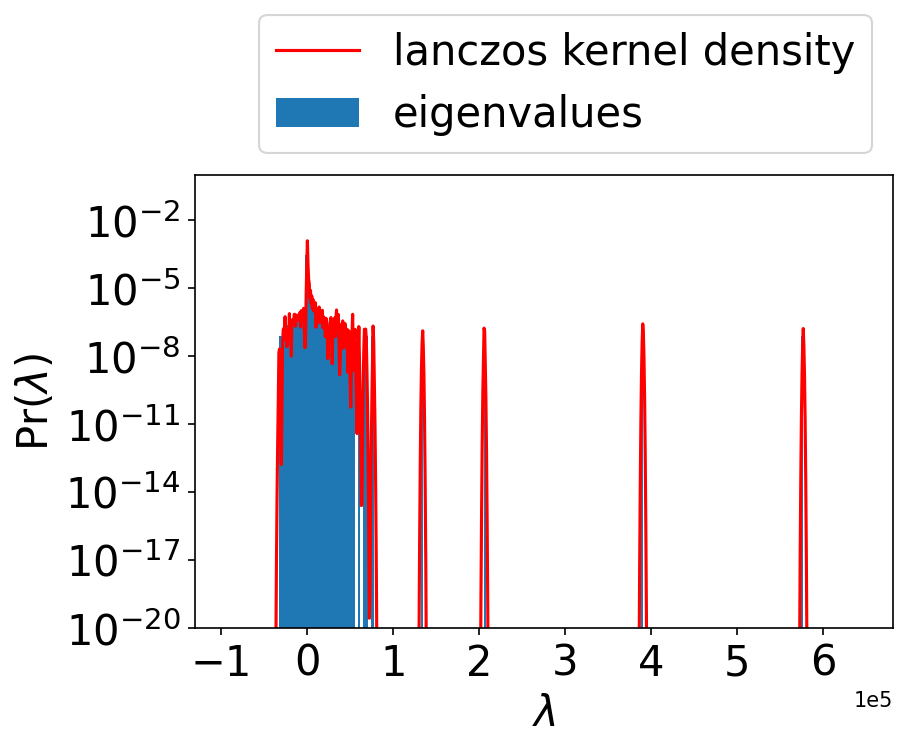

In [ ]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

n = 200 #number of bins in the histogram
plt.tight_layout()
plt.ticklabel_format(axis='both', style='scientific', scilimits=(0, 0))
plt.hist(eigenvalues, bins =n, label = 'eigenvalues', density = True)
plt.plot(x, density, 'r-', label = 'lanczos kernel density')
plt.yscale('log')
plt.ylim((1e-20, 1))
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.4))

plt.xlabel(r'$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'Pr($\lambda)$', fontsize=20)
plt.savefig('dense_lan.png')

### Training the network:

In [ ]:
batch_size=16
epochs=5

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_test, y_test),
    verbose = 1)

Epoch 1/5
3750/3750 [==============================] - 6s 1ms/step - loss: 0.7408 - sparse_categorical_accuracy: 0.7889 - val_loss: 0.4692 - val_sparse_categorical_accuracy: 0.8655
Epoch 2/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4638 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.4240 - val_sparse_categorical_accuracy: 0.8775
Epoch 3/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4342 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.4035 - val_sparse_categorical_accuracy: 0.8851
Epoch 4/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4195 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.3937 - val_sparse_categorical_accuracy: 0.8870
Epoch 5/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4096 - sparse_categorical_accuracy: 0.8852 - val_loss: 0.3891 - val_sparse_categorical_accuracy: 0.8887


In [ ]:
#parameters of the approximation:
M =  np.int64(128)  #number of approximated eigenvalues for the density
kappa = 1.1          #parameter of standard deviation of the gauß kernels sigma = 2/((M-1)*np.sqrt(8*np.log(kappa)))
points = 1024        #number of points of the spectral approximation
N = 5

start = time.time()   
x_trained, density_trained = kernel_density(model, M, kappa, points, x_train, y_train, N)
end = time.time()
print("Calculation of kernel density: %s"  % (end - start))

start = time.time()
hessian_trained = extract_hessian(model, x_train, y_train)
eigenvalues_trained = eigenvals(hessian_trained)
end = time.time()
print("Calculation of hessian eigenvalues with numba: %s"  % (end - start))

number of densities to average: 5
density 1 approximated
density 2 approximated
density 3 approximated
density 4 approximated
density 5 approximated
Calculation of kernel density: 365.9341011047363
Calculation of hessian eigenvalues with numba: 654.7634718418121


### Plotting the eigenvalues and kernel density of the trained network:

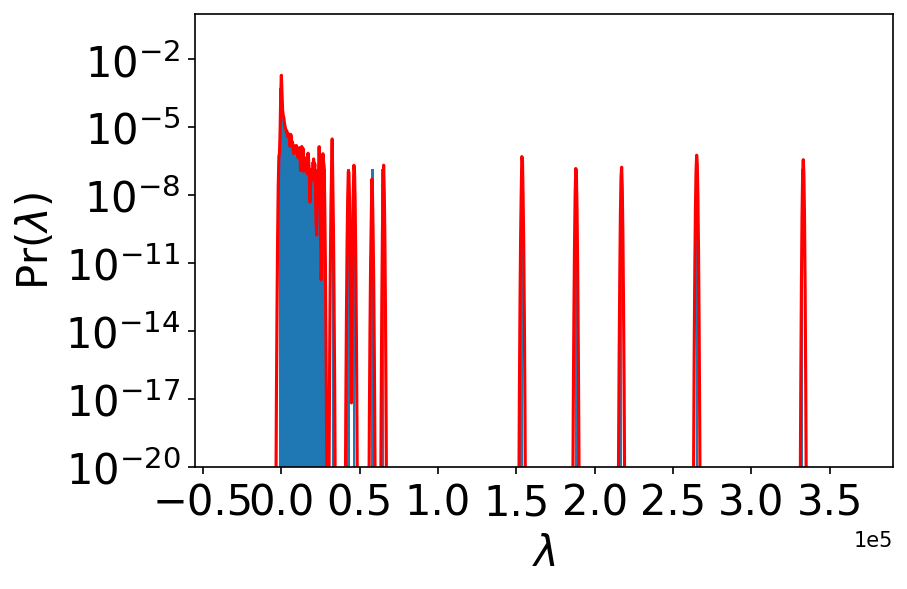

In [ ]:
n = 200 #number of bins in the histogram
plt.tight_layout()
plt.ticklabel_format(axis='both', style='scientific', scilimits=(0, 0))
plt.hist(eigenvalues_trained, bins =n, label = 'eigenvalues', density = True)
plt.plot(x_trained, density_trained, 'r-', label = 'lanczos kernel density')
plt.yscale('log')
plt.ylim((1e-20, 1))
#plt.legend(fontsize=20, bbox_to_anchor=(1, 1.4))

plt.xlabel(r'$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'Pr($\lambda)$', fontsize=20)
plt.savefig('dense_lan_trained.png')

### Comparing the spectra of trained and untrained network

Text(0, 0.5, 'Pr($\\lambda)$')

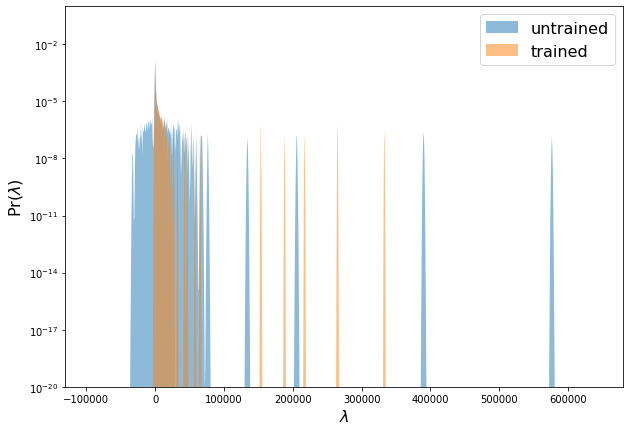

In [ ]:
plt.figure(figsize = (15, 10))

plt.fill_between(x, density, label = 'untrained', alpha = 0.5)
plt.fill_between(x_trained, density_trained,label = 'trained', alpha = 0.5)

plt.yscale('log')
plt.ylim((1e-20, 1))
plt.legend(fontsize=20)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'Pr($\lambda)$', fontsize=20)

## Exploring a network with 1e5 paramaters trained on the fashion-MNIST dataset

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

learning_rate=0.01
hidden_layer=128

model=tf.keras.models.Sequential([
                                  
                      tf.keras.layers.Flatten(input_shape=(28,28)),
                      tf.keras.layers.Dense(hidden_layer,activation=None),
                      tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print('Number of parameters: ' + str(get_parameter_number(model)))

4423680/4422102 [==============================] - 0s 0us/step
Number of parameters: 101770


In [ ]:
#parameters of the approximation:
M =  np.int64(128)  #number of approximated eigenvalues for the density
kappa = 1.1          #parameter of standard deviation of the gauß kernels 
points = 1024        #number of points of the spectral approximation
N = 1               #number of densities to average
    
start = time.time()   
x_fashion, density_fashion = kernel_density(model, M, kappa, points, x_train, y_train, N)
end = time.time()
print("Calculation of kernel density: %s"  % (end - start))

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 220.62810730934143


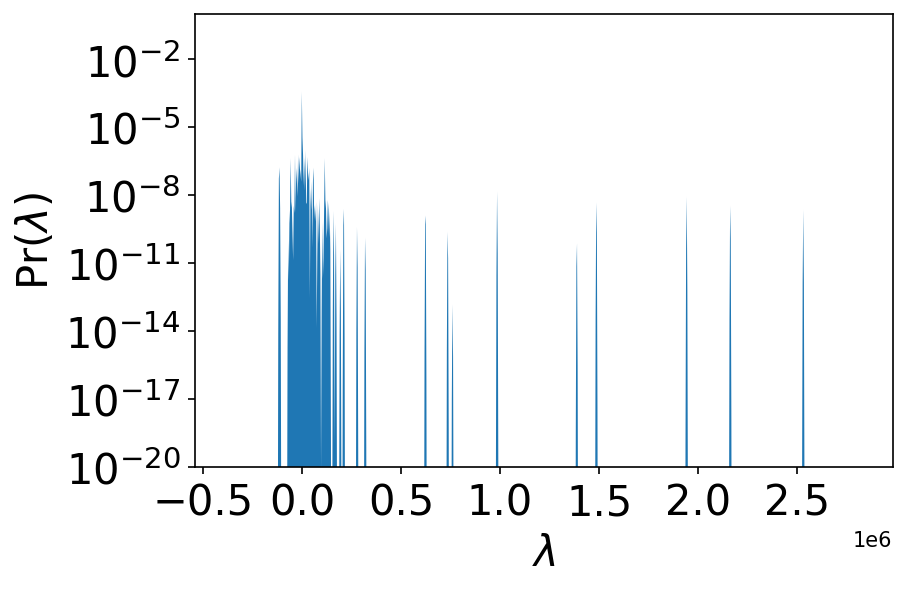

In [ ]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

n = 200 #number of bins in the histogram
plt.tight_layout()
plt.ticklabel_format(axis='both', style='scientific', scilimits=(0, 0))
plt.fill_between(x_fashion, density_fashion)
plt.yscale('log')
plt.ylim((1e-20, 1))

plt.xlabel(r'$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'Pr($\lambda)$', fontsize=20)
plt.savefig('dense_lan_large.png')

### Checking the influence of the parameter $M_0$ of the approximation

No handles with labels found to put in legend.


number of densities to average: 1
density 1 approximated
Calculation of kernel density: 73.42118692398071


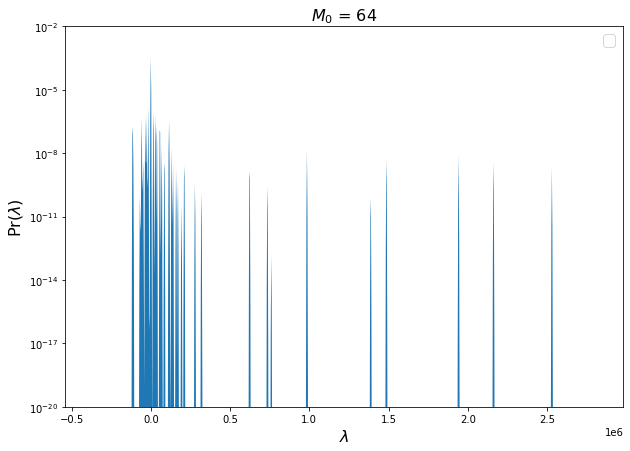

No handles with labels found to put in legend.


number of densities to average: 1
density 1 approximated
Calculation of kernel density: 144.67536449432373


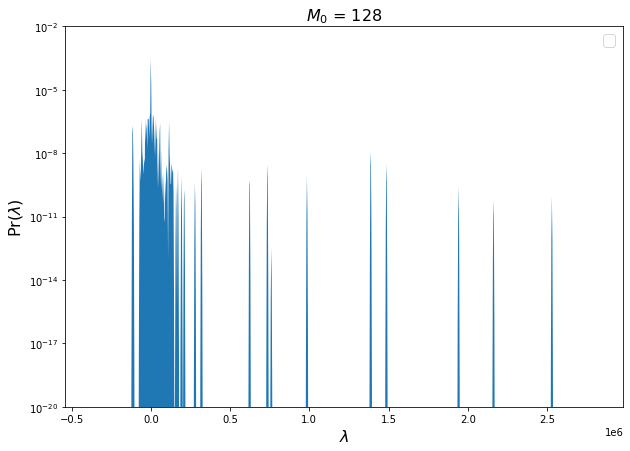

No handles with labels found to put in legend.


number of densities to average: 1
density 1 approximated
Calculation of kernel density: 291.2262313365936


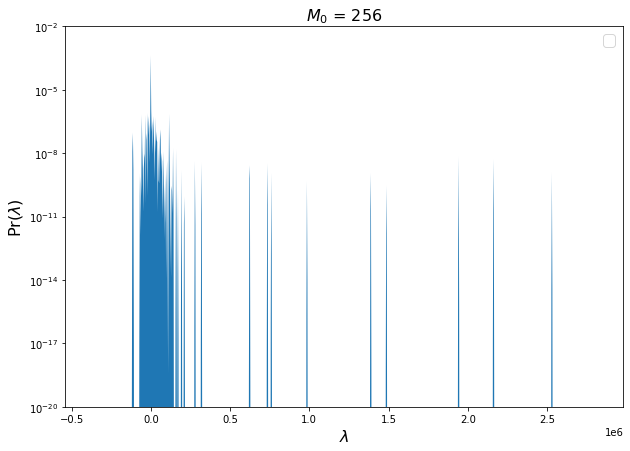

No handles with labels found to put in legend.


number of densities to average: 1
density 1 approximated
Calculation of kernel density: 584.4119050502777


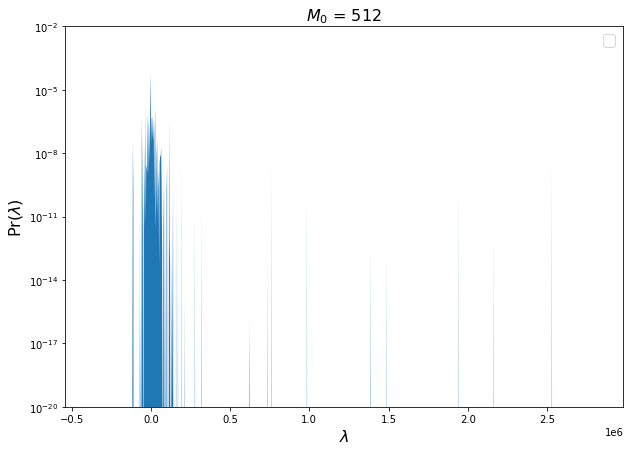

In [ ]:
for m_0 in [64, 128, 256, 512]:

#parameters of the approximation:
  M =  m_0  #number of approximated eigenvalues for the density
  kappa = 1.1          #parameter of standard deviation of the gauß kernels 
  points = 1024        #number of points of the spectral approximation
  N = 1               #number of densities to average
    
  start = time.time()   
  x_fashion, density_fashion = kernel_density(model, M, kappa, points, x_train, y_train, N)
  end = time.time()
  print("Calculation of kernel density: %s"  % (end - start))
  plt.figure(figsize = (10, 7))

  plt.fill_between(x_fashion, density_fashion)

  plt.yscale('log')
  plt.ylim((1e-20, 10e-3))
  plt.legend(fontsize=16)
  plt.title(r'$M_0$ = ' + str(M), fontsize=16)
  plt.xlabel(r'$\lambda$', fontsize=16)
  plt.ylabel(r'Pr($\lambda)$', fontsize=16)
  plt.show()


### Plotting the spectral density troughout the training process

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 211.50251531600952


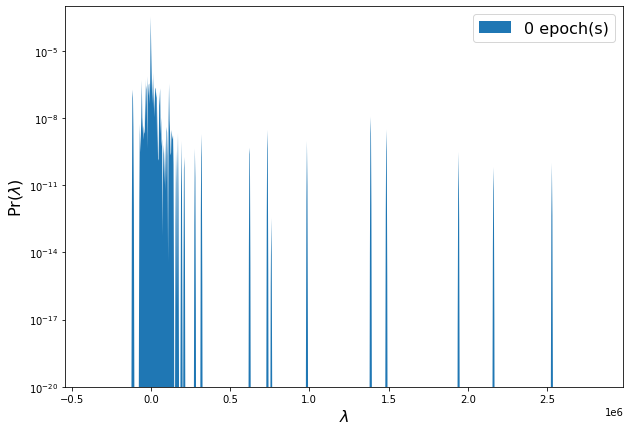

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 210.90243411064148


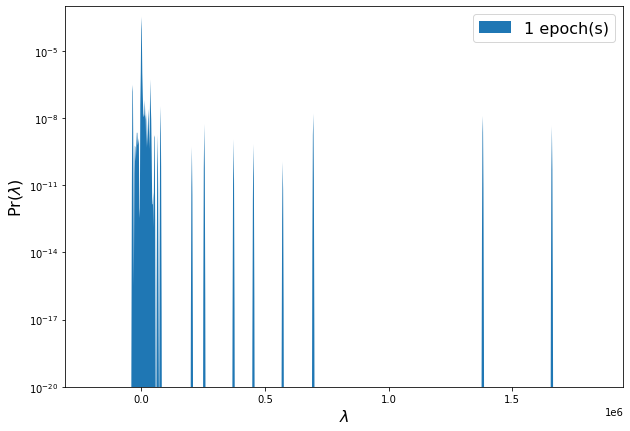

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 211.5777027606964


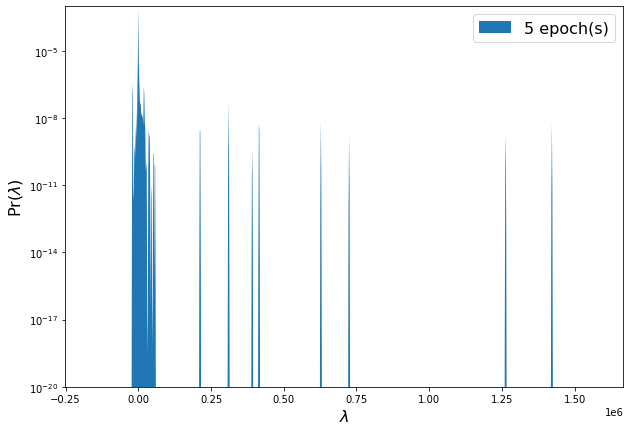

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 210.0191080570221


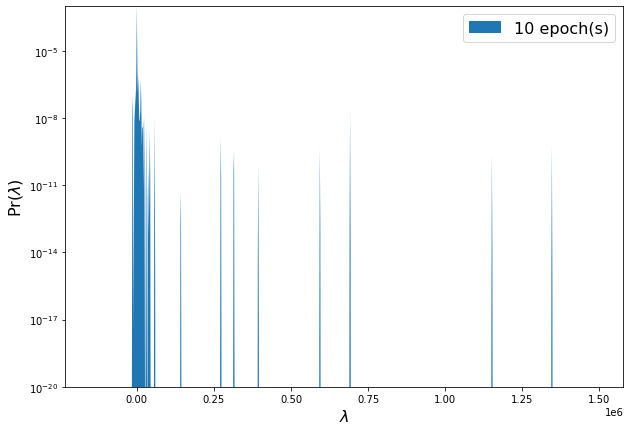

In [ ]:
learning_rate=0.01
hidden_layer=128
nos_epoch = [0, 1, 5, 10]
batch_size=16
M = 128
kappa = 1.1
points = 1024
N = 1

for index, ep in  enumerate(nos_epoch):

  tf.random.set_seed(1234)
  model=tf.keras.models.Sequential([
                                  
                      tf.keras.layers.Flatten(input_shape=(28,28)),
                      tf.keras.layers.Dense(hidden_layer,activation=None),
                      tf.keras.layers.Dense(10, activation='softmax'),
  ])

  model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  if index > 0:
    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size = batch_size,
        epochs = ep,
        verbose = 0,
        validation_data=(x_test, y_test)
    )
  
  start = time.time()   
  x_fashion, density_fashion = kernel_density(model, M, kappa, points, x_train, y_train, N)
  end = time.time()
  print("Calculation of kernel density: %s"  % (end - start))
  plt.figure(figsize = (10, 7))
  plt.fill_between(x_fashion, density_fashion, alpha = 1, label = str(ep) + ' epoch(s)')
  plt.yscale('log')
  plt.ylim((1e-20, 1e-3))
  plt.legend(fontsize=16)
  plt.xlabel(r'$\lambda$', fontsize=16)
  plt.ylabel(r'Pr($\lambda)$', fontsize=16)
  plt.show()

### Comparison of the spectrum for train and test data

In [ ]:
start = time.time()   
x_fashion_test, density_fashion_test = kernel_density(model, M, kappa, points, x_test, y_test, N)
end = time.time()
print("Calculation of kernel density: %s"  % (end - start))

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 43.02539348602295


Text(0, 0.5, 'Pr($\\lambda)$')

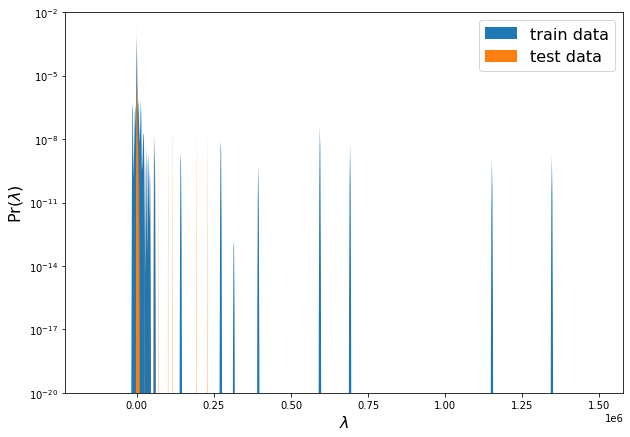

In [ ]:
plt.figure(figsize = (10, 7))

plt.fill_between(x_fashion, density_fashion, label = 'train data')
plt.fill_between(x_fashion_test, density_fashion_test, label = 'test data')
plt.yscale('log')
plt.ylim((1e-20, 10e-3))
#plt.xlim((-0.02e6, 0.1e6))
plt.legend(fontsize=16)
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel(r'Pr($\lambda)$', fontsize=16)

### Influence of data normalization

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train/255.0, x_test/255.0

learning_rate=0.01
hidden_layer=128

model=tf.keras.models.Sequential([
                                  
                      tf.keras.layers.Flatten(input_shape=(28,28)),
                      tf.keras.layers.Dense(hidden_layer,activation=None),
                      tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print('Number of parameters: ' + str(get_parameter_number(model)))

Number of parameters: 101770


In [ ]:
start = time.time()   
x_fashion, density_fashion = kernel_density(model, M, kappa, points, x_train, y_train, N)
x_fashion_norm, density_fashion_norm = kernel_density(model, M, kappa, points, x_train_norm, y_train, N)
end = time.time()
print("Calculation of kernel densities: %s"  % (end - start))

number of densities to average: 1
density 1 approximated
number of densities to average: 1
density 1 approximated
Calculation of kernel densities: 448.54535722732544


Text(0, 0.5, 'Pr($\\lambda)$')

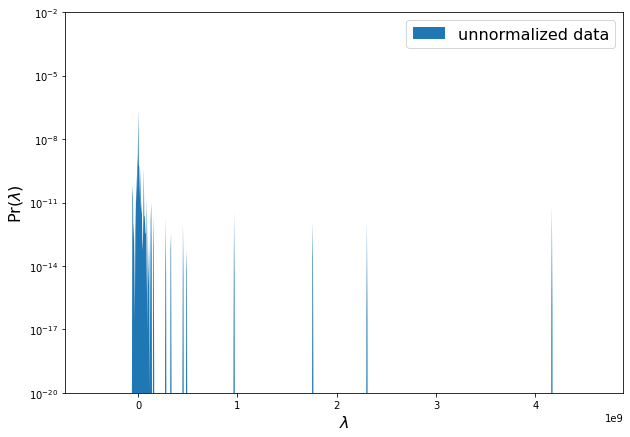

In [ ]:
plt.figure(figsize = (10, 7))

plt.fill_between(x_fashion, density_fashion, label = 'unnormalized data')

plt.yscale('log')
plt.ylim((1e-20, 10e-3))
#plt.xlim((-0.02e6, 0.1e6))
plt.legend(fontsize=16)
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel(r'Pr($\lambda)$', fontsize=16)

Text(0, 0.5, 'Pr($\\lambda)$')

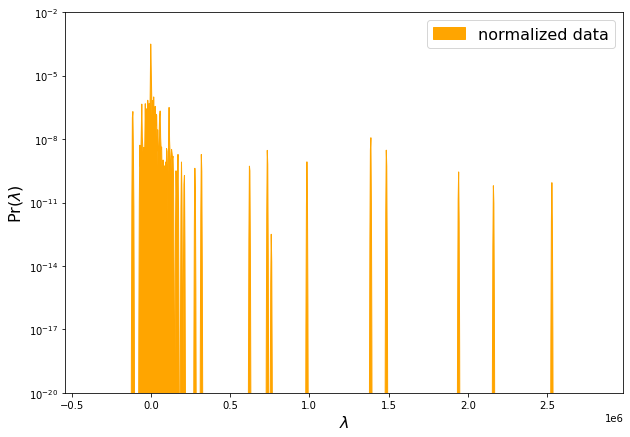

In [ ]:
plt.figure(figsize = (10, 7))

plt.fill_between(x_fashion_norm, density_fashion_norm, color = 'orange', label = 'normalized data')
plt.yscale('log')
plt.ylim((1e-20, 10e-3))
#plt.xlim((-0.02e6, 0.1e6))
plt.legend(fontsize=16)
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel(r'Pr($\lambda)$', fontsize=16)

## Exploring the Hessian of a convolutional neural network

In [ ]:
from tensorflow.keras import layers

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

x_train = np.reshape(x_train ,(x_train.shape[0], 28, 28,1))
x_test = np.reshape(x_test ,(x_test.shape[0], 28, 28,1)) 

batch_size = 10
feature_maps1 = 10
feature_maps2 = 20
#number neurons fully connected layers
layer = 64
epochs = 10
dropout = 0.5
learning_rate = 0.03

model = tf.keras.models.Sequential()
# add the first convolutional Layer 
model.add(layers.Conv2D( filters=feature_maps1 ,kernel_size= (5, 5), activation='relu' , input_shape = ( 28, 28, 1) ) )
model.add(layers.MaxPooling2D((2, 2)  ))
# add the second convolutional Layer 
model.add(layers.Conv2D( filters=feature_maps2 ,kernel_size= (5, 5),     activation='relu'  ) )
model.add(layers.MaxPooling2D((2, 2) ))
# fully connected Layers with Dropout
model.add(layers.Flatten())
model.add(layers.Dense(layer,   activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(10,  activation='softmax' ))

    # compile the model
model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

print('Number of parameters: ' + str(get_parameter_number(model)))

Number of parameters: 26474


In [ ]:
#train it
model.fit(x_train, y_train,
          batch_size= batch_size,
	        verbose=1,
          validation_data=(x_test, y_test),
          epochs=epochs)

Epoch 1/10
6000/6000 [==============================] - 45s 7ms/step - loss: 0.9628 - accuracy: 0.6396 - val_loss: 0.4756 - val_accuracy: 0.8240
Epoch 2/10
6000/6000 [==============================] - 44s 7ms/step - loss: 0.5239 - accuracy: 0.8080 - val_loss: 0.3990 - val_accuracy: 0.8527
Epoch 3/10
6000/6000 [==============================] - 43s 7ms/step - loss: 0.4494 - accuracy: 0.8362 - val_loss: 0.3584 - val_accuracy: 0.8636
Epoch 4/10
6000/6000 [==============================] - 44s 7ms/step - loss: 0.4099 - accuracy: 0.8503 - val_loss: 0.3535 - val_accuracy: 0.8652
Epoch 5/10
6000/6000 [==============================] - 44s 7ms/step - loss: 0.3892 - accuracy: 0.8566 - val_loss: 0.3365 - val_accuracy: 0.8762
Epoch 6/10
6000/6000 [==============================] - 43s 7ms/step - loss: 0.3641 - accuracy: 0.8681 - val_loss: 0.3500 - val_accuracy: 0.8711
Epoch 7/10
6000/6000 [==============================] - 44s 7ms/step - loss: 0.3647 - accuracy: 0.8675 - val_loss: 0.3197 - val_ac

In [ ]:
#parameters of the approximation:
M =  np.int64(64)  #number of approximated eigenvalues for the density
kappa = 1.1          #parameter of standard deviation of the gauß kernels 
points = 1024        #number of points of the spectral approximation
N = 1               #number of densities to average
    
start = time.time()   
x_fashion, density_fashion = kernel_density(model, M, kappa, points, x_train, y_train, N)
end = time.time()
print("Calculation of kernel density: %s"  % (end - start))

number of densities to average: 1
density 1 approximated
Calculation of kernel density: 4078.6791174411774


Text(0, 0.5, 'Pr($\\lambda)$')

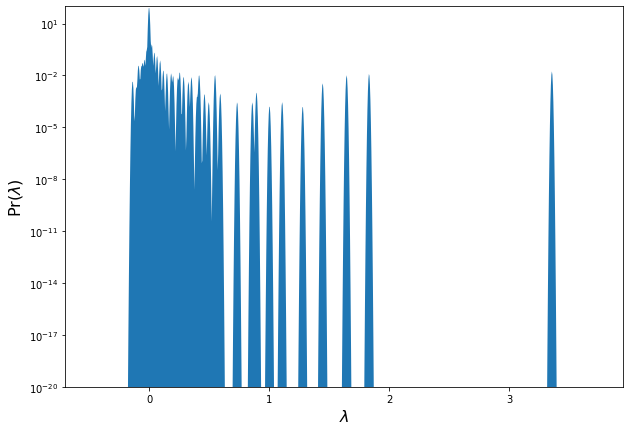

In [ ]:
plt.figure(figsize = (10, 7))

plt.fill_between(x_fashion, density_fashion)

plt.yscale('log')
plt.ylim((1e-20, 10e1))
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel(r'Pr($\lambda)$', fontsize=16)